# Hands-on Day 4

## You'll learn

### ML methods

- Gradient Boosting Trees with xgboost

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [96]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
# Check out these custom functions
from custom_functions import *

num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-annalisagilioli>

In [98]:
#spark.stop()

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [100]:
inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 233 ms, sys: 157 ms, total: 390 ms
Wall time: 78 ms


In [101]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

99999

In [102]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [103]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

99999
99999


# ML model: GBT

- xgboost uses the parameter n_jobs to spawn multi-core jobs on the SAME machine
- do not abuse it or you'll eat up all resources (set it to 5 max)

In [104]:
# DO NOT Use all available cores NJOBS = -1 
NJOBS = 40

In [105]:
# pip install xgboost

In [106]:
import xgboost as xgb

# Define the XGBoost classifier with multi-core support
gbt = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees (can be adjusted)
    max_depth=6,           # Maximum depth of each tree (can be tuned)
    learning_rate=0.1,     # Learning rate (can be tuned)
    n_jobs=NJOBS,             # DO NOT Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)

# Train the model
%time gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = gbt.predict(x_test)

CPU times: user 21.2 s, sys: 187 ms, total: 21.3 s
Wall time: 562 ms


In [107]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7294
Precision: 0.7437
Recall: 0.7498
F1-Score: 0.7467


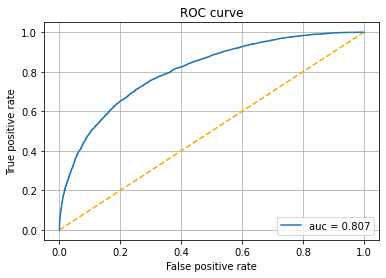

In [108]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

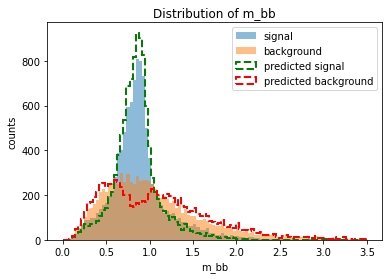

In [109]:
def plotSignalvsBgWithPrediction2(x_test, y_test, y_pred, variable):
    
    def isSignal(x, y):
        if (y>=0.5):
            return x
        else: 
            return -1.
    
    def isBackground(x, y):
        if (y<0.5):
            return x
        else: 
            return -1.
    
    isSignalNP = np.vectorize(isSignal)
    isBackgroundNP = np.vectorize(isBackground)

    x_signal = isSignalNP(x_test, y_test)
    x_background = isBackgroundNP(x_test, y_test)
    x_signal_pred = isSignalNP(x_test, y_pred)
    x_background_pred = isBackgroundNP(x_test, y_pred)

    f, ax = plt.subplots()
    plt.hist(x_signal, bins = 100, range=[0, 3.5], alpha=0.5, label='signal') 
    plt.hist(x_background, bins = 100, range=[0, 3.5], alpha=0.5, label='background') 
    plt.hist(x_signal_pred, bins = 100, range=[0, 3.5], label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2) 
    plt.hist(x_background_pred, bins = 100, range=[0, 3.5], label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2) 
    
    plt.title("histogram") 
    ax.set_xlabel(variable)
    ax.set_ylabel('counts')
    ax.legend()
    ax.set_title("Distribution of "+variable)
    plt.show()
    f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')

    return
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred, 'm_bb')

# Hyperparameter scan

In [110]:
# Get the default hyperparameters
default_params = gbt.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 6
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: 40
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: 1


## Exercise 1

- do hyperparameter optimisation using Randomized Grid search
- select a reasonable number and range of hyperparameters
- DO NOT USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Creazione del modello
xgb = XGBClassifier()

# Definizione della distribuzione dei parametri da testare
param_dist = {
    'n_estimators': np.arange(50, 200, 50),
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': np.arange(3, 10, 2),
    'min_child_weight': np.arange(1, 6, 1),
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
}

# Ricerca casuale con cross-validation
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
random_search.fit(x_train, y_train)

# Visualizzazione dei risultati migliori
print("Migliori parametri:", random_search.best_params_)
print("Migliore score:", random_search.best_score_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Migliori parametri: {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Migliore score: 0.7238465081513038


## Exercise 2

- Run the best model on full dataset

In [126]:
import xgboost as xgb
gbt = xgb.XGBClassifier(
    n_estimators=150,      # Number of trees (can be adjusted)
    max_depth=7,           # Maximum depth of each tree (can be tuned)
    learning_rate=0.1,     # Learning rate (can be tuned)
    min_child_weight=3,            # DO NOT Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)

# Train the model
%time gbt.fit(x_train, y_train)

# Make predictions on the test set
y_pred = gbt.predict(x_test)

CPU times: user 1min 46s, sys: 79.6 ms, total: 1min 46s
Wall time: 2.34 s


In [127]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7318
Precision: 0.7450
Recall: 0.7540
F1-Score: 0.7495


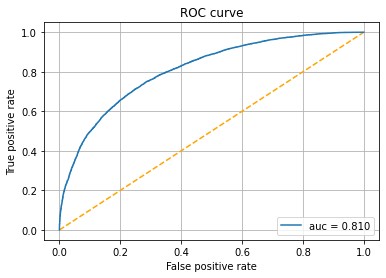

In [128]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

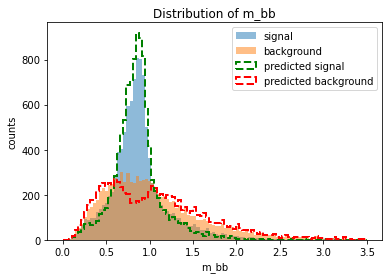

In [129]:
def plotSignalvsBgWithPrediction2(x_test, y_test, y_pred, variable):
    
    def isSignal(x, y):
        if (y>=0.5):
            return x
        else: 
            return -1.
    
    def isBackground(x, y):
        if (y<0.5):
            return x
        else: 
            return -1.
    
    isSignalNP = np.vectorize(isSignal)
    isBackgroundNP = np.vectorize(isBackground)

    x_signal = isSignalNP(x_test, y_test)
    x_background = isBackgroundNP(x_test, y_test)
    x_signal_pred = isSignalNP(x_test, y_pred)
    x_background_pred = isBackgroundNP(x_test, y_pred)

    f, ax = plt.subplots()
    plt.hist(x_signal, bins = 100, range=[0, 3.5], alpha=0.5, label='signal') 
    plt.hist(x_background, bins = 100, range=[0, 3.5], alpha=0.5, label='background') 
    plt.hist(x_signal_pred, bins = 100, range=[0, 3.5], label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2) 
    plt.hist(x_background_pred, bins = 100, range=[0, 3.5], label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2) 
    
    plt.title("histogram") 
    ax.set_xlabel(variable)
    ax.set_ylabel('counts')
    ax.legend()
    ax.set_title("Distribution of "+variable)
    plt.show()
    f.savefig("SignalvsBackgroundPred.pdf", bbox_inches='tight')

    return
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred, 'm_bb')

In [130]:
#Once done, stop spark
spark.stop()